[*********************100%***********************]  1 of 1 completed
Epoch 1/20
44/44 [==============================] - 2s 5ms/step - loss: 0.0339
Epoch 2/20
44/44 [==============================] - 0s 4ms/step - loss: 7.2496e-04
Epoch 3/20
44/44 [==============================] - 0s 5ms/step - loss: 3.3295e-04
Epoch 4/20
44/44 [==============================] - 0s 4ms/step - loss: 3.2264e-04
Epoch 5/20
44/44 [==============================] - 0s 4ms/step - loss: 2.9510e-04
Epoch 6/20
44/44 [==============================] - 0s 4ms/step - loss: 3.0958e-04
Epoch 7/20
44/44 [==============================] - 0s 4ms/step - loss: 2.8164e-04
Epoch 8/20
44/44 [==============================] - 0s 4ms/step - loss: 2.7415e-04
Epoch 9/20
44/44 [==============================] - 0s 4ms/step - loss: 2.9781e-04
Epoch 10/20
44/44 [==============================] - 0s 4ms/step - loss: 2.6362e-04
Epoch 11/20
44/44 [==============================] - 0s 4ms/step - loss: 2.7206e-04
Epoch 12/20
44/44 [=

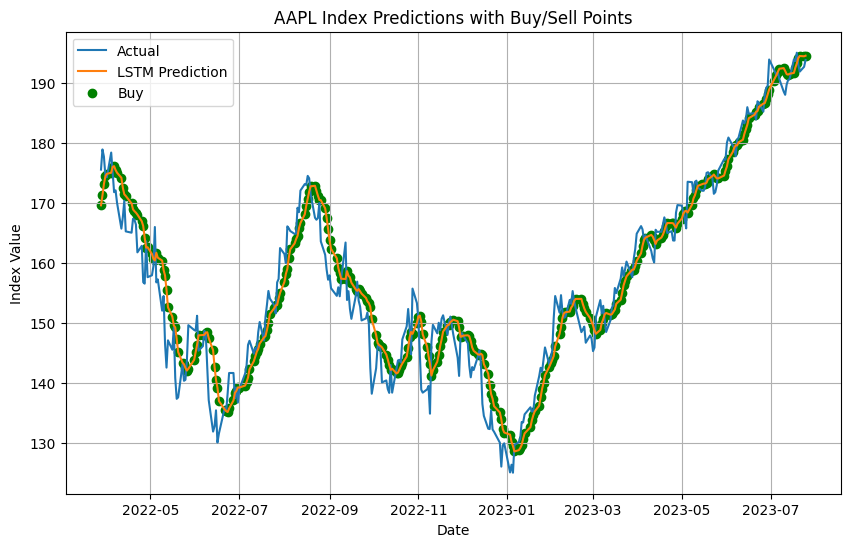

In [76]:
import warnings
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import yfinance as yf
from keras.layers import LSTM, Dense
from keras.models import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

warnings.simplefilter("ignore")

tf.random.set_seed(455)
np.random.seed(455)

ticker = "AAPL"
end = datetime.now()
start = datetime(2016, end.month, end.day)
dataset = yf.download(ticker, start, end)

# Preprocess the data
data = dataset['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split the data into train and test sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]


# Function to create sequences for LSTM models
def create_dataset(dataset, time_steps=1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        data_X.append(a)
        data_Y.append(dataset[i + time_steps, 0])
    return np.array(data_X), np.array(data_Y)


# Define sequence length
sequence_length = 20

# Create sequences for LSTM models
X_train, y_train = create_dataset(train_data, sequence_length)
X_test, y_test = create_dataset(test_data, sequence_length)


# Build the LSTM model
def build_lstm_model(lr):
    lstm_model = Sequential()
    lstm_model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
    lstm_model.add(Dense(1))
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    lstm_model.compile(optimizer=optimizer, loss='mean_squared_error')
    return lstm_model


# # Define hyperparameter grid for grid search
# param_grid = {
#     'learning_rate': [0.001, 0.01, 0.1],
#     'epochs': [10, 20, 30],
#     'batch_size': [16, 32, 64]
# }
#
# best_params = None
# best_rmse = float('inf')

# Grid search for best hyperparameters
# for params in ParameterGrid(param_grid):
#     lstm_model = build_lstm_model(lr=params['learning_rate'])
#     lstm_model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0)
#     lstm_predictions = lstm_model.predict(X_test)
#     lstm_predictions = scaler.inverse_transform(lstm_predictions)
#     lstm_rmse = np.sqrt(mean_squared_error(data[train_size + sequence_length:], lstm_predictions))
#
#     if lstm_rmse < best_rmse:
#         best_rmse = lstm_rmse
#         best_params = params
#
# print("Best hyperparameters:")
# print(best_params)

# Build and train the LSTM model with best hyperparameters
# lstm_model = build_lstm_model(lr=best_params['learning_rate'])
# lstm_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)

# Delete this part
chosen_learning_rate = 0.001
chosen_epochs = 20
chosen_batch_size = 32
lstm_model = build_lstm_model(lr=chosen_learning_rate)
lstm_model.fit(X_train, y_train, epochs=chosen_epochs, batch_size=chosen_batch_size, verbose=1)

# Generate predictions for the LSTM model
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)


# Function to calculate Theil U statistic
def theil_u_statistic(actual, predicted, naive):
    mse_actual = mean_squared_error(actual, naive)
    mse_predicted = mean_squared_error(actual, predicted)
    theil_u = np.sqrt(mse_predicted / mse_actual)
    return theil_u


# Generate naive predictions (using the last value in the training set)
naive_predictions = np.full_like(y_test, y_train[-1])

# Calculate indexes
lstm_rmse = np.sqrt(mean_squared_error(data[train_size + sequence_length:], lstm_predictions))
lstm_mae = mean_absolute_error(data[train_size + sequence_length:], lstm_predictions)
lstm_r2 = r2_score(data[train_size + sequence_length:], lstm_predictions)
lstm_mape = mean_absolute_percentage_error(data[train_size + sequence_length:], lstm_predictions)
lstm_theil_u = theil_u_statistic(data[train_size + sequence_length:], lstm_predictions, naive_predictions)

print(f"RMSE: {lstm_rmse}")
print(f"MAE: {lstm_mae}")
print(f"R2: {lstm_r2}")
print(f"MAPE: {lstm_mape:.2f}%")
print(f"Theil U statistic : {lstm_theil_u:.2f}")

lstm_predictions_list = lstm_predictions.flatten().tolist()


# Function to get price direction (rise or fall) from predictions
def get_price_direction(predictions):
    price_direction = np.zeros_like(predictions)
    price_direction[1:] = np.sign(predictions[1:] - predictions[:-1])
    return price_direction


# Get price direction from LSTM predictions
lstm_price_direction = get_price_direction(lstm_predictions)

# Initialize variables for the trading strategy
initial_balance = 1000  # Initial balance (USD)
balance = initial_balance
stocks = 0
N = len(lstm_price_direction)

# Implement the trading strategy
for i in range(N):
    if lstm_price_direction[i] == 1:  # Predicted price will rise
        stocks_to_buy = int(balance / dataset['Close'][i + train_size])
        stocks += stocks_to_buy
        balance -= stocks_to_buy * dataset['Close'][i + train_size]
    elif lstm_price_direction[i] == -1:  # Predicted price will fall
        balance += stocks * dataset['Close'][i + train_size]
        stocks = 0

# Calculate profit or loss
final_balance = balance + stocks * dataset['Close'][-1]
profit_or_loss = final_balance - initial_balance

print(f"Initial Balance: ${initial_balance}")
print(f"Final Balance: ${final_balance:.2f}")
print(f"Profit or Loss: ${profit_or_loss:.2f}")

# Plot the predictions with buy/sell points
plt.figure(figsize=(10, 6))
plt.plot(dataset.index[train_size + sequence_length:], data[train_size + sequence_length:], label='Actual')
plt.plot(dataset.index[train_size + sequence_length:], lstm_predictions_list, label='LSTM Prediction')
plt.scatter(dataset.index[train_size + sequence_length:], lstm_predictions_list, marker='o', color='g',
            label='Buy' if lstm_price_direction[-1] == 1 else 'Sell')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.title(f'{ticker} Index Predictions with Buy/Sell Points')
plt.legend()
plt.grid(True)
plt.show()
